In [14]:
import orekit
import numpy as np
from scenarios.utils.utility import get_vel, get_vels, get_apo, rocket_equation, mass_fraction

vm = orekit.initVM()
print ('Java version:',vm.java_version)
print ('Orekit version:', orekit.VERSION)

from orekit.pyhelpers import setup_orekit_curdir, download_orekit_data_curdir
setup_orekit_curdir()

from org.orekit.utils import Constants


Java version: 1.8.0_382
Orekit version: 12.0.1
File or folder: /home/chris/git/space/src/orekit-data.zip  not found


        The Orekit library relies on some external data for physical models. 
        Typical data are the Earth Orientation Parameters and the leap seconds history, 
        both being provided by the IERS or the planetary ephemerides provided by JPL. 
        Such data is stored in text or binary files with specific formats that Orekit knows 
        how to read, and needs to be provided for the library to work.

        You can download a starting file with this data from the orekit gitlab at:
        https://gitlab.orekit.org/orekit/orekit-data

        or by the function:
        orekit.pyhelpers.download_orekit_data_curdir()

        


In [15]:

###

RE = Constants.WGS84_EARTH_EQUATORIAL_RADIUS
MU = Constants.WGS84_EARTH_MU

print(f'using Constants.WGS84_EARTH_EQUATORIAL_RADIUS {Constants.WGS84_EARTH_EQUATORIAL_RADIUS} as RE')
print(f'using Constants.WGS84_EARTH_MU {Constants.WGS84_EARTH_MU} as MU')

g_test = MU / RE**2

print(f'g (m/s^2) = {g_test}')


## TODO: Reconsider MUs ?

MU_JPL = Constants.JPL_SSD_EARTH_GM

print(f'mu = {MU}')
print(f'mu_jpl = {MU_JPL}')
print(f'mu - mujpl = {MU - MU_JPL}')

RM = Constants.MOON_EQUATORIAL_RADIUS


using Constants.WGS84_EARTH_EQUATORIAL_RADIUS 6378137.0 as RE
using Constants.WGS84_EARTH_MU 398600441800000.0 as MU
g (m/s^2) = 9.7982854791873
mu = 398600441800000.0
mu_jpl = 398600436738211.56
mu - mujpl = 5061788.4375


In [16]:
###

h_leo = 185e3 # m
h_geo = 36000e3 # m


R_leo = h_leo + RE
R_geo = h_geo + RE

v_geo = get_vel( R_geo, R_geo, MU )

print(f'v_geo (km/s) = {v_geo/1000}')


(vp_gto,va_gto) = get_vels( R_leo, R_geo, MU )

print(f'vp_gto (km/s) = {vp_gto/1000}, va_gto (km/s) = {va_gto/1000}')

dv_gto2geo = v_geo - va_gto
print(f'DV GTO 2 GEO = v_geo - va_gto (m/s) = {dv_gto2geo}')




v_geo (km/s) = 3.066888291825575
vp_gto (km/s) = 10.255608789236996, va_gto (km/s) = 1.588294584591261
DV GTO 2 GEO = v_geo - va_gto (m/s) = 1478.5937072343138


In [17]:
MU_L = Constants.JPL_SSD_MOON_GM

# https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html
RE_MP = 363104e3
RE_MA = 405696e3
RE_M = np.mean([RE_MA,RE_MP])
print(f'RE_M (km) = {RE_M/1000}')


# TODO: check me: apogee of low earth LTI orbit
R_a_LTI = 384400e3

(vp_lti,va_lti) = get_vels( R_leo, R_a_LTI, MU )

print(f'vp_lti (km/s) = {vp_lti/1000}, va_lti (km/s) = {va_lti/1000}')

dv_gto2lti = vp_lti - vp_gto
print(f'DV GTO 2 LTI = vp_lti - vp_gto (m/s) = {dv_gto2lti}')



RE_M (km) = 384400.0
vp_lti (km/s) = 10.928283047140303, va_lti (km/s) = 0.18658641730790695
DV GTO 2 LTI = vp_lti - vp_gto (m/s) = 672.6742579033071


In [18]:
### GEO to Lunar Transfer (2.5km/s from bard = .7 circ + 1.3 raise + .5 inc)


(vp_geo2lti,va_geo2lti) = get_vels( R_geo, R_a_LTI, MU )

print(f'vp_geo2lti (km/s) = {vp_geo2lti/1000}, va_geo2lti (km/s) = {va_geo2lti/1000}')

dv_geo2lti = vp_geo2lti - v_geo

print(f'DV GEO 2 LTI = vp_geo2lti - v_geo (m/s) = {dv_geo2lti}')



vp_geo2lti (km/s) = 4.116267245518918, va_geo2lti (km/s) = 0.45379744344228246
DV GEO 2 LTI = vp_geo2lti - v_geo (m/s) = 1049.3789536933427


In [19]:
### Lunar Capture (640 m/s from bard to 100 km circ [+ 120 m/s for direct transfers])
# : (chatGPT says 1.5 - 2 km/s)

dv_lti2llo = 760

h_llo = 100e3

v_llo = get_vel( h_llo+RM, h_llo+RM, MU_L )

(vp_l2s,va_l2s) = get_vels( RM, h_llo+RM, MU_L )

# https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html
print(f'moon radius = {RM}')
print(f'MU_L (m^3/s^2) = {MU_L*10**-12} *10^12')
print(f'MU (Gkm^3/s^2) = {MU * 10**-9 * 10**-6}, MU_L (Gkm^3/s^2) = {MU_L * 10**-9 * 10**-6}')
print(f'escape velocity = 2.38 km/s (11.2 for earth)')
v_ls = 0 # once every 30 days right ?

# Sidereal rotation period (hrs)	655.720
w_L = 2*np.pi / (655.72*3600)
v_ls = w_L * RM

print(f'v_ls = {v_ls}')
print(f'vp_l2s = {vp_l2s}')
print(f'va_l2s = {va_l2s}')
print(f'v_llo = {v_llo}')

dv_ls2l2s = vp_l2s - v_ls
print(f'DV LS 2 L2S = vp_l2s - v_ls (m/s) = {dv_ls2l2s}')

dv_l2s2llo = v_llo - va_l2s
print(f'DV L2S 2 LLO = v_llo - va_l2s (m/s) = {dv_l2s2llo}')

print(f'RM (km) = {RM/1000}')


# dv_gto2geo = 0
# dv_geo2lti = 900
# dv_lti2llo = 900

print(f'GTO 2 GEO : {dv_gto2geo:10.0f} \t raise')
print(f'GEO 2 LTI : {dv_geo2lti:10.0f} \t lunar injection')
print(f'LTI 2 LLO : {dv_lti2llo:10.0f} \t lunar orbit capture')
print(f'LLO 2 L2S : {dv_l2s2llo:10.0f} \t lunar descent burn')
print(f'L2S 2 LS  : {dv_ls2l2s:10.0f} \t lunar landing burn')




moon radius = 1737400.0
MU_L (m^3/s^2) = 4.902798458429648 *10^12
MU (Gkm^3/s^2) = 0.39860044180000004, MU_L (Gkm^3/s^2) = 0.004902798458429647
escape velocity = 2.38 km/s (11.2 for earth)
v_ls = 4.624435799449381
vp_l2s = 1703.1899706600493
va_l2s = 1610.4943153503698
v_llo = 1633.5038575843078
DV LS 2 L2S = vp_l2s - v_ls (m/s) = 1698.5655348605999
DV L2S 2 LLO = v_llo - va_l2s (m/s) = 23.009542233937964
RM (km) = 1737.4
GTO 2 GEO :       1479 	 raise
GEO 2 LTI :       1049 	 lunar injection
LTI 2 LLO :        760 	 lunar orbit capture
LLO 2 L2S :         23 	 lunar descent burn
L2S 2 LS  :       1699 	 lunar landing burn


In [20]:
###


# Isp = 350 # Lox Methane
Isp = 450
g0 = 9.8
m_spacecraft = 10e3
# m_dump = 10e3
m_dump = np.linspace(0, 50e3, num=50)

m_l2s2ls = m_spacecraft * mass_fraction( dv_ls2l2s, Isp, g0 )
print(f'm_l2s2ls = {m_l2s2ls}')

m_llo_return = m_l2s2ls * mass_fraction( dv_l2s2llo, Isp, g0 )
print(f'm_llo = {m_llo_return}')

m_lti2llo = m_llo_return * mass_fraction( dv_lti2llo, Isp, g0 )
print(f'm_lti2llo = {m_lti2llo}')

m_gto2geo = m_lti2llo * mass_fraction( dv_geo2lti, Isp, g0 )
print(f'm_gto2geo = {m_gto2geo}')

m_gto_return = m_gto2geo * mass_fraction( dv_gto2geo, Isp, g0 )
print(f'm_gto_return = {m_gto_return}')

m_gto_arrive = m_gto_return + m_dump
print(f'm_gto_arrive = {m_gto_arrive}')

m_geo2gto = m_gto_arrive * mass_fraction( dv_gto2geo, Isp, g0 )
print(f'm_geo2gto = {m_geo2gto}')

m_lti2geo = m_geo2gto * mass_fraction( dv_geo2lti, Isp, g0 )
print(f'm_lti2geo = {m_lti2geo}')

m_llo_depart = m_lti2geo * mass_fraction( dv_lti2llo, Isp, g0 )
print(f'm_llo_depart = {m_llo_depart}')

m_l2s = m_llo_depart * mass_fraction( dv_l2s2llo, Isp, g0 )
print(f'm_l2s = {m_l2s}')

m_ls = m_l2s * mass_fraction( dv_ls2l2s, Isp, g0 )
print(f'm_ls = {m_ls}')



m_l2s2ls = 14698.527898294762
m_llo = 14775.419110310315
m_lti2llo = 17554.328013720813
m_gto2geo = 22270.322025993526
m_gto_return = 31141.36379434362
m_gto_arrive = [31141.36379434 32161.77195761 33182.18012087 34202.58828414
 35222.9964474  36243.40461067 37263.81277394 38284.2209372
 39304.62910047 40325.03726373 41345.445427   42365.85359026
 43386.26175353 44406.66991679 45427.07808006 46447.48624332
 47467.89440659 48488.30256985 49508.71073312 50529.11889638
 51549.52705965 52569.93522292 53590.34338618 54610.75154945
 55631.15971271 56651.56787598 57671.97603924 58692.38420251
 59712.79236577 60733.20052904 61753.6086923  62774.01685557
 63794.42501883 64814.8331821  65835.24134536 66855.64950863
 67876.05767189 68896.46583516 69916.87399843 70937.28216169
 71957.69032496 72978.09848822 73998.50665149 75018.91481475
 76039.32297802 77059.73114128 78080.13930455 79100.54746781
 80120.95563108 81141.36379434]
m_geo2gto = [ 43546.04921472  44972.92134499  46399.79347526  47826.66

In [21]:
###


m_spacecraft = m_l2s2ls
m_burned = m_ls - m_dump - m_spacecraft

mass_ratio = m_burned / (m_burned + m_spacecraft)
print(f'm_spacecraft = {m_spacecraft}')
print(f'm_burned = {m_burned}')
print(f'm_dump = {m_dump}')
print(f'm_burned / (m_burned + m_spacecraft) = {m_burned / (m_burned + m_spacecraft)}')

print(f'm_burned / (m_burned + m_dump) = {m_burned / (m_burned + m_dump)}')


m_spacecraft = 14698.527898294762
m_burned = [ 82279.92599887  84437.2080187   86594.49003853  88751.77205836
  90909.05407819  93066.33609803  95223.61811786  97380.90013769
  99538.18215752 101695.46417735 103852.74619718 106010.02821701
 108167.31023684 110324.59225667 112481.8742765  114639.15629634
 116796.43831617 118953.720336   121111.00235583 123268.28437566
 125425.56639549 127582.84841532 129740.13043515 131897.41245498
 134054.69447481 136211.97649465 138369.25851448 140526.54053431
 142683.82255414 144841.10457397 146998.3865938  149155.66861363
 151312.95063346 153470.23265329 155627.51467312 157784.79669296
 159942.07871279 162099.36073262 164256.64275245 166413.92477228
 168571.20679211 170728.48881194 172885.77083177 175043.0528516
 177200.33487143 179357.61689126 181514.8989111  183672.18093093
 185829.46295076 187986.74497059]
m_dump = [    0.          1020.40816327  2040.81632653  3061.2244898
  4081.63265306  5102.04081633  6122.44897959  7142.85714286
  8163.26530

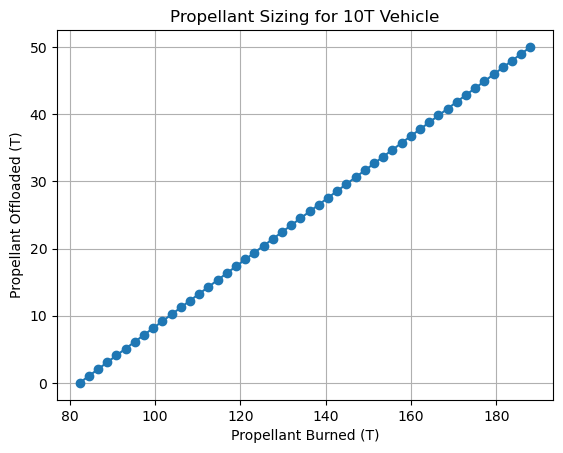

In [22]:
import matplotlib.pyplot as plt

# Plotting
plt.plot( m_burned/1000, m_dump/1000, marker='o', linestyle='-' )

# Adding labels and title
title = 'Propellant Sizing for 10T Vehicle'
plt.xlabel('Propellant Burned (T)')
plt.ylabel('Propellant Offloaded (T)')
plt.title(title)
plt.grid()
# Display the plot
plt.savefig(title.replace(' ','_') + '.png')
plt.show()


